In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import sys
sys.stderr = open(os.devnull, 'w')
import cv2
import csv
import shutil
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import CustomObjectScope
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D,MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D

# Data Exploration

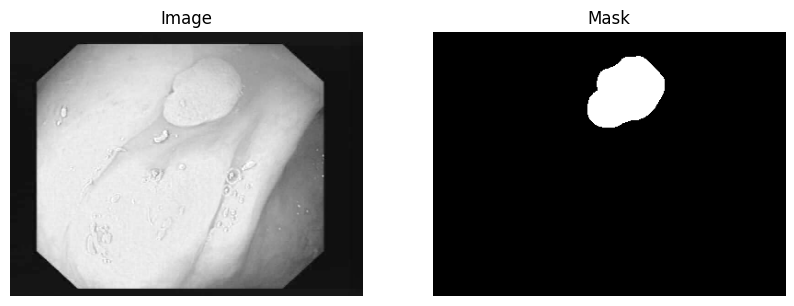

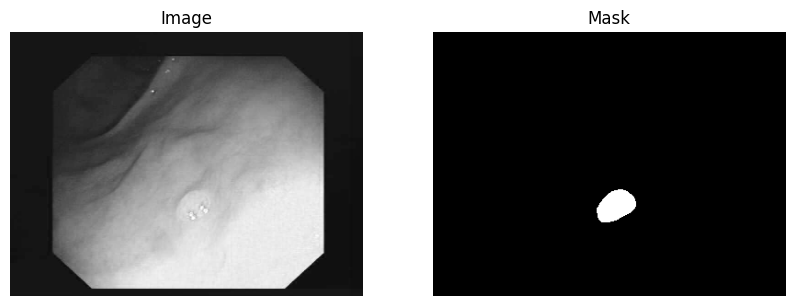

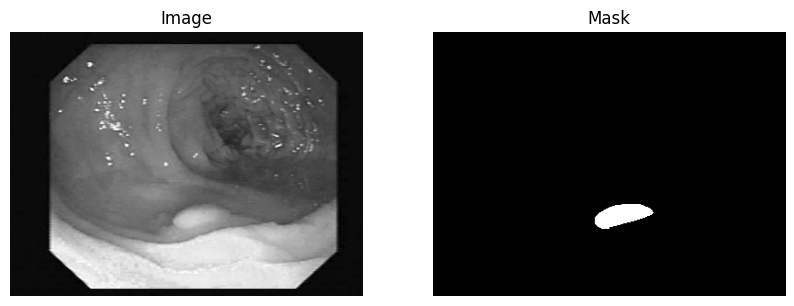

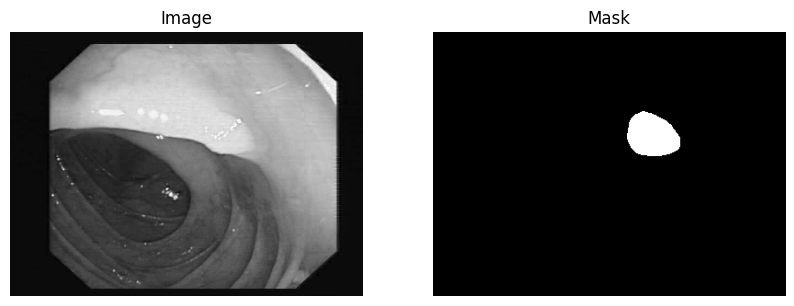

In [3]:
image_dir = "/kaggle/input/cvcclinicdb/CVC-ClinicDB/images/"
mask_dir = "/kaggle/input/cvcclinicdb/CVC-ClinicDB/masks/"

image_files = os.listdir(image_dir)[5:9]

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, image_file)

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Image')
    axes[0].axis('off')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

In [4]:
np.random.seed(42)

H = 256
W = 256

In [5]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=valid_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=valid_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
path = "/kaggle/input/cvcclinicdb/CVC-ClinicDB"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
print(len(train_x), len(valid_x), len(test_x))

490 61 61


# Reading Dataset

In [7]:
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

In [12]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

In [13]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)             
    return x

In [14]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    
    return x, y


In [15]:
def tf_dataset(X, Y, batch = 8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


In [16]:
ds = tf_dataset(test_x, test_y, 8)
for x,y in ds:
    print(x.shape, y.shape)
    break

(8, 256, 256, 3) (8, 256, 256, 1)


In [17]:
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Train: {len(test_x)} - {len(test_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 490 - 490
Train: 61 - 61
Valid: 61 - 61


# Building ResUnet Model

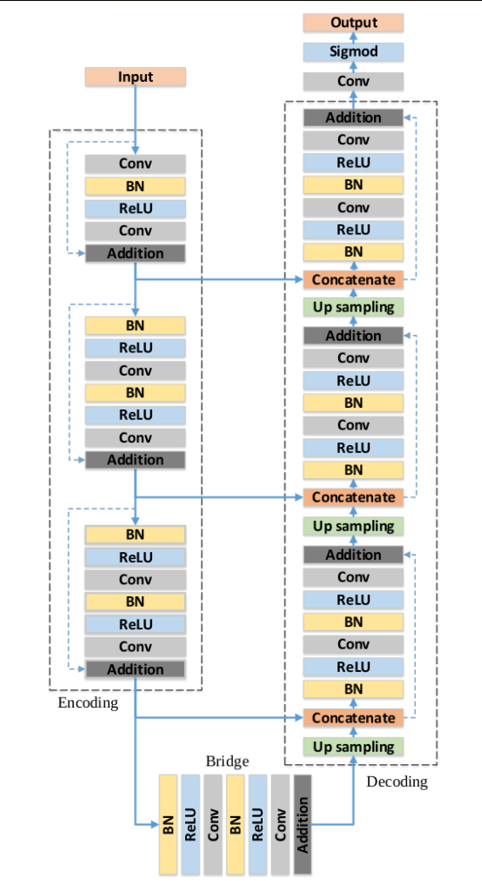

In [18]:
def res_block(inputs, filters):
    x = Conv2D(filters, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(filters, (1, 1), padding="same")(inputs)
    shortcut = BatchNormalization()(shortcut)
    
    x = tf.keras.layers.Add()([shortcut, x])
    x = Activation("relu")(x)
    
    return x

In [19]:
def ResUNet(input_shape):
    inputs = Input(input_shape)

    c1 = res_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = res_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = res_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = res_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = res_block(p4, 1024)
    
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = res_block(u6, 512)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = res_block(u7, 256)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = res_block(u8, 128)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = res_block(u9, 64)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

batch = 8
lr = 1e-4
epochs = 15

In [21]:
resunet_model = ResUNet((256, 256, 3))

resunet_model.compile(loss="binary_crossentropy" , optimizer=Adam(lr), metrics=["accuracy",Recall(), Precision()])

In [ ]:
resunet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_5[0][0]  

# Training Part

In [26]:
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

In [27]:
def create_dir(path):
    try:
        os.makedirs(path, exist_ok=True)
        print(f"Directory '{path}' created successfully")
    except OSError as error:
        print(f"Error creating directory '{path}': {error}")

In [28]:
def remove_dir(path):
    """ Remove a directory and its contents. """
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"Directory {path} and its contents have been removed.")
    else:
        print(f"Directory {path} does not exist.")

In [29]:
create_dir("/kaggle/working/files_1")

Directory '/kaggle/working/files_1' created successfully


In [30]:
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1

In [31]:
print(f"Training steps: {train_steps}, Validation steps: {valid_steps}")

Training steps: 62, Validation steps: 8


In [32]:
csv_file_path = os.path.join("files_1", "training_log.csv")
csv_file = open(csv_file_path, "w", newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["epoch", "loss", "accuracy", "recall", "precision", "val_loss", "val_accuracy", "val_recall", "val_precision"])

85

In [33]:
history_dict = {
    'loss': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_recall': [],
    'val_precision': []
}

In [34]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    epoch_history = resunet_model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=1,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        verbose=1
    )

    loss = epoch_history.history['loss'][0]
    accuracy = epoch_history.history['accuracy'][0]
    recall = epoch_history.history['recall'][0]
    precision = epoch_history.history['precision'][0]
    val_loss = epoch_history.history['val_loss'][0]
    val_accuracy = epoch_history.history['val_accuracy'][0]
    val_recall = epoch_history.history['val_recall'][0]
    val_precision = epoch_history.history['val_precision'][0]

    csv_writer.writerow([epoch+1, loss, accuracy, recall, precision, val_loss, val_accuracy, val_recall, val_precision])

    history_dict['loss'].append(loss)
    history_dict['accuracy'].append(accuracy)
    history_dict['recall'].append(recall)
    history_dict['precision'].append(precision)
    history_dict['val_loss'].append(val_loss)
    history_dict['val_accuracy'].append(val_accuracy)
    history_dict['val_recall'].append(val_recall)
    history_dict['val_precision'].append(val_precision)

    
csv_file.close()

Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 113s 821ms/step - accuracy: 0.8327 - loss: 0.4004 - precision: 0.1905 - recall: 0.1693 - val_accuracy: 0.9124 - val_loss: 0.4569 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step - accuracy: 0.9106 - loss: 0.2265 - precision: 0.5605 - recall: 0.1887 - val_accuracy: 0.9124 - val_loss: 0.3240 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step - accuracy: 0.9149 - loss: 0.2090 - precision: 0.5951 - recall: 0.2723 - val_accuracy: 0.9124 - val_loss: 0.2990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step - accuracy: 0.9231 - loss: 0.1905 - precision: 0.6692 - recall: 0.3530 - val_accuracy: 0.8975 - val_loss: 0.3231 - val_precision: 0.0604 - val_recall: 0.0117
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 245ms/step - accuracy: 0.9304 - loss: 0.1750 - precision: 0.7140 - recall: 0.4274 - val_a

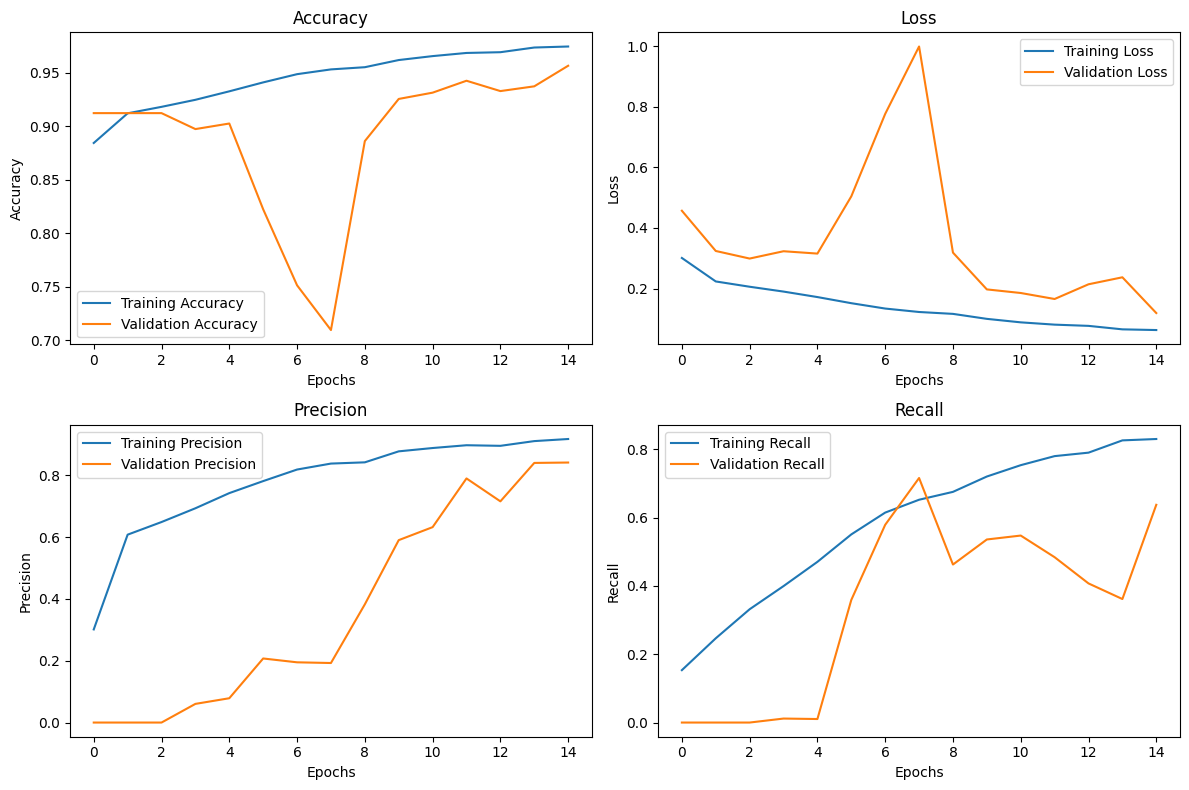

In [37]:
plt.figure(figsize=(12, 8))
    
    
plt.subplot(2, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

    
plt.subplot(2, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(history_dict['precision'], label='Training Precision')
plt.plot(history_dict['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()


plt.subplot(2, 2, 4)
plt.plot(history_dict['recall'], label='Training Recall')
plt.plot(history_dict['val_recall'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


In [58]:
resunet_model.save('/kaggle/working/resunet_1.keras')

# Model Prediction

In [38]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    ori_x = x
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    ori_x = x
    x = x / 255.0
    x = x.astype(np.int32)
    return ori_x, x

In [39]:
def save_results(ori_x, ori_y, y_pred, save_img_path):
    line = np.ones((ori_x.shape[0], 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    cat_image = np.concatenate([ori_x, line, ori_y, line, y_pred * 255], axis=1)
    cv2.imwrite(save_img_path, cat_image)

In [40]:
SCORE = []

In [41]:
create_dir("/kaggle/working/results_1")

Directory '/kaggle/working/results_1' created successfully


In [42]:

for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    name = os.path.splitext(os.path.basename(x))[0]

    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    y_pred = resunet_model.predict(x)[0] > 0.5
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred.astype(np.int32)

    save_img_path = f"/kaggle/working/results_1/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_img_path)

    y = y.flatten()
    y_pred = y_pred.flatten()

    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

In [43]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")


Accuracy: 0.95242
F1: 0.64726
Jaccard: 0.53020
Recall: 0.63822
Precision: 0.75802


In [44]:
df = pd.DataFrame(SCORE, columns=["Image Name", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("/kaggle/working/files_1/score.csv")

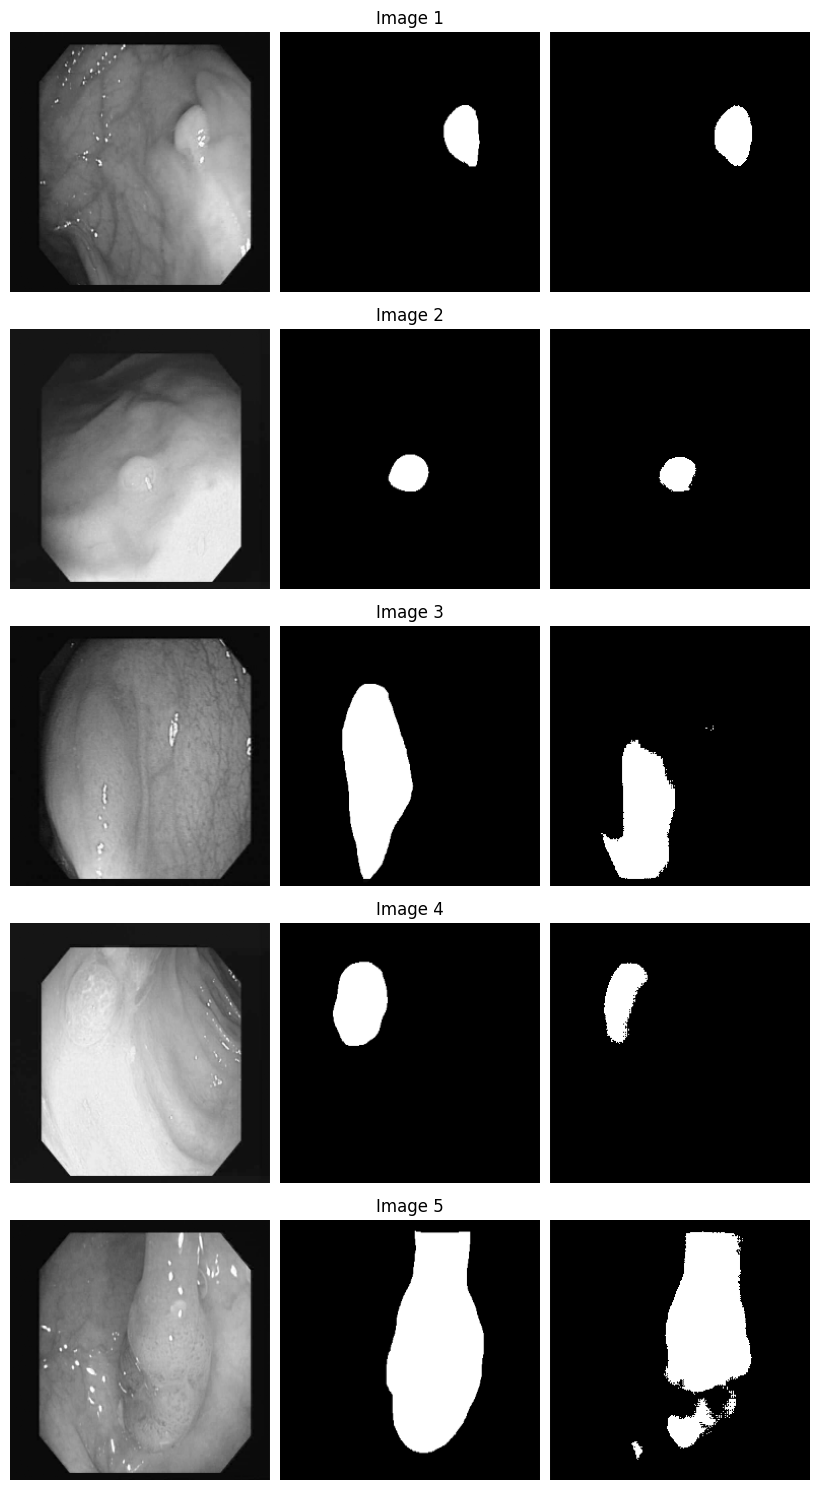

In [61]:
result_dir = "/kaggle/working/results_1"

image_files = [f for f in os.listdir(result_dir) if f.endswith(".png")]

fig, axes = plt.subplots(5, 1, figsize=(30, 15))

for i, image_file in enumerate(image_files[35:40]):
    image_path = os.path.join(result_dir, image_file)
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()